In [3]:
import numpy as np
import pandas as pd 
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
import sklearn as sklearn
from sklearn.model_selection import train_test_split
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import RMSprop
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

## 1. Preparando los datos

Llamaremos al DataFrame 'data' de momento.

In [4]:
data = pd.read_csv('https://github.com/anabautistamartin/capstonedatasci/files/8984239/dataset.csv',sep=';',header=None, decimal=',')
print(data)

      0   1           2   3     4     5         6      7   8   9   10  11
0      1  76  110.037736   0  0.90  0.50  0.875000  1.000   0   0   0   0
1      1  76   92.905660   0  0.80  0.50  0.806250  0.900   0   0   0   0
2      1  76   84.207547   0  0.50  0.60  0.912500  0.950   0   0   0   0
3      1  76   63.169811   0  0.95  0.90  0.887500  0.900   0   0   0   0
4      1  76   62.452830   0  0.60  0.70  0.787500  1.000   0   0   0   0
...   ..  ..         ...  ..   ...   ...       ...    ...  ..  ..  ..  ..
7520   0  69   62.932584   1  0.45  0.35  0.361429  0.850   1   1   1   1
7521   0  69  185.112360   1  0.02  0.30  0.050000  0.925   1   1   1   1
7522   0  69  128.617977   1  0.10  0.40  0.014286  0.775   1   1   1   1
7523   0  69   74.932584   1  0.60  0.60  0.556250  1.000   1   1   1   1
7524   0  69   84.865169   1  0.30  0.25  0.234286  0.975   1   1   1   1

[7525 rows x 12 columns]


### Poniendo nombre a las columnas y reorganizándolas

Queremos que quede en el orden 'profic', 'item', 'ms', 'lang', 'expo', 'pref', 'use', 'grupo', 'orden', 'contextlab1' y 'contextlab2'. 'Profic', que es el nivel de competencia en la lengua y lo que buscamos predecir, pasará a llamarse 'predict'. 

In [5]:
data.columns = ['version', 'item', 'ms', 'lang', 'expo', 'pref', 'use', 'profic', 'grupo', 'orden', 'contextlab1', 'contextlab2']

data = data.reindex(columns=['profic', 'item', 'ms', 'lang', 'expo', 'pref', 'use', 'grupo', 'orden', 'contextlab1', 'contextlab2', 'version'])

data.rename(columns = {'profic':'predict'}, inplace = True)
print(data)

      predict  item          ms  lang  expo  pref       use  grupo  orden  \
0       1.000    76  110.037736     0  0.90  0.50  0.875000      0      0   
1       0.900    76   92.905660     0  0.80  0.50  0.806250      0      0   
2       0.950    76   84.207547     0  0.50  0.60  0.912500      0      0   
3       0.900    76   63.169811     0  0.95  0.90  0.887500      0      0   
4       1.000    76   62.452830     0  0.60  0.70  0.787500      0      0   
...       ...   ...         ...   ...   ...   ...       ...    ...    ...   
7520    0.850    69   62.932584     1  0.45  0.35  0.361429      1      1   
7521    0.925    69  185.112360     1  0.02  0.30  0.050000      1      1   
7522    0.775    69  128.617977     1  0.10  0.40  0.014286      1      1   
7523    1.000    69   74.932584     1  0.60  0.60  0.556250      1      1   
7524    0.975    69   84.865169     1  0.30  0.25  0.234286      1      1   

      contextlab1  contextlab2  version  
0               0            0   

### Haciendo one-hot-encoding de la columna 'item'

La variable 'item' es una variable categórica que indica, del 1 al 146, el número de ítem que lee el sujeto. Para un procesamiento adecuado, esta variable se tiene que descomponer en variables dicotómicas 0-1.

Tendremos ahora un DataFrame que incluya todas las variables dicotómicas de 'item', llamado 'dataset'. 

In [6]:
dummies_item = pd.get_dummies(data['item'])

dataset = pd.merge(
    left=data,
    right=dummies_item,
    left_index=True,
    right_index=True,
)

del dataset['item']

print(dataset)

      predict          ms  lang  expo  pref       use  grupo  orden  \
0       1.000  110.037736     0  0.90  0.50  0.875000      0      0   
1       0.900   92.905660     0  0.80  0.50  0.806250      0      0   
2       0.950   84.207547     0  0.50  0.60  0.912500      0      0   
3       0.900   63.169811     0  0.95  0.90  0.887500      0      0   
4       1.000   62.452830     0  0.60  0.70  0.787500      0      0   
...       ...         ...   ...   ...   ...       ...    ...    ...   
7520    0.850   62.932584     1  0.45  0.35  0.361429      1      1   
7521    0.925  185.112360     1  0.02  0.30  0.050000      1      1   
7522    0.775  128.617977     1  0.10  0.40  0.014286      1      1   
7523    1.000   74.932584     1  0.60  0.60  0.556250      1      1   
7524    0.975   84.865169     1  0.30  0.25  0.234286      1      1   

      contextlab1  contextlab2  ...  136  137  138  140  141  142  143  144  \
0               0            0  ...    0    0    0    0    0    0   

### Normalizando 'ms'

La variable 'ms' indica el tiempo de lectura del ítem en milisegundos, ponderado según la longitud del ítem en número de caracteres. Esta variable tiene un rango diferente a las demás variables, y por eso se debe normalizar.

In [7]:
dataset['ms'] = MinMaxScaler().fit_transform(np.array(dataset['ms']).reshape(-1,1)) 
  
print(dataset['ms'])
print(dataset)

0       0.227130
1       0.187630
2       0.167576
3       0.119072
4       0.117419
          ...   
7520    0.118525
7521    0.400220
7522    0.269968
7523    0.146192
7524    0.169092
Name: ms, Length: 7525, dtype: float64
      predict        ms  lang  expo  pref       use  grupo  orden  \
0       1.000  0.227130     0  0.90  0.50  0.875000      0      0   
1       0.900  0.187630     0  0.80  0.50  0.806250      0      0   
2       0.950  0.167576     0  0.50  0.60  0.912500      0      0   
3       0.900  0.119072     0  0.95  0.90  0.887500      0      0   
4       1.000  0.117419     0  0.60  0.70  0.787500      0      0   
...       ...       ...   ...   ...   ...       ...    ...    ...   
7520    0.850  0.118525     1  0.45  0.35  0.361429      1      1   
7521    0.925  0.400220     1  0.02  0.30  0.050000      1      1   
7522    0.775  0.269968     1  0.10  0.40  0.014286      1      1   
7523    1.000  0.146192     1  0.60  0.60  0.556250      1      1   
7524    0.975  

### Separando la variable a predecir

Queremos predecir la variable de nivel de competencia en la lengua, que corresponde a la columna 'predict'. La separamos del resto del dataset bajo el nombre 'tags'.

In [8]:
tags = dataset["predict"]
print(tags)

variables = dataset
del variables['predict']
print(variables)

0       1.000
1       0.900
2       0.950
3       0.900
4       1.000
        ...  
7520    0.850
7521    0.925
7522    0.775
7523    1.000
7524    0.975
Name: predict, Length: 7525, dtype: float64
            ms  lang  expo  pref       use  grupo  orden  contextlab1  \
0     0.227130     0  0.90  0.50  0.875000      0      0            0   
1     0.187630     0  0.80  0.50  0.806250      0      0            0   
2     0.167576     0  0.50  0.60  0.912500      0      0            0   
3     0.119072     0  0.95  0.90  0.887500      0      0            0   
4     0.117419     0  0.60  0.70  0.787500      0      0            0   
...        ...   ...   ...   ...       ...    ...    ...          ...   
7520  0.118525     1  0.45  0.35  0.361429      1      1            1   
7521  0.400220     1  0.02  0.30  0.050000      1      1            1   
7522  0.269968     1  0.10  0.40  0.014286      1      1            1   
7523  0.146192     1  0.60  0.60  0.556250      1      1            1   

### Separando los sets de Train y Test

En este caso destinamos un 80% de los datos a entrenar el modelo, y un 20% a testarlo. Obtenemos así las variables X_train y y_train para entrenar el modelo, y las variables X_test y y_test para testarlo.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(variables,tags, test_size=0.2)
print(X_train)
print(X_test)
print(y_train)
print(y_test)
print(np.shape(X_train))
print(np.shape(y_train))

            ms  lang  expo  pref       use  grupo  orden  contextlab1  \
5924  0.102280     0  0.25  0.30  0.206250      1      1            0   
3689  0.141763     0  0.80  0.20  0.631250      1      0            1   
1640  0.064414     0  0.80  1.00  0.912500      0      0            1   
3448  0.127966     1  0.50  0.10  0.437500      1      0            0   
2194  0.152062     0  0.90  0.50  0.837500      0      0            1   
...        ...   ...   ...   ...       ...    ...    ...          ...   
6587  0.120202     0  0.40  0.50  0.875000      1      1            1   
6896  0.083295     0  0.15  0.05  0.171429      1      1            1   
7466  0.307162     1  0.45  0.35  0.361429      1      1            1   
3814  0.055242     1  0.30  0.10  0.043750      1      0            1   
6410  0.162794     1  0.05  0.40  0.075000      1      1            1   

      contextlab2  version  ...  136  137  138  140  141  142  143  144  145  \
5924            1        0  ...    0    0  

## 2. Implementando el modelo

### Construyendo el modelo

Construimos un modelo secuencial con 16 capas de neuronas densamente conectadas. Se incluye también un dropout del 20% de neuronas cada dos capas, para reducir el riesgo de overfitting del modelo. El input para que el modelo sea entrenado es un DataFrame de 155 columnas. La última neurona del modelo tiene activación **lineal** puesto que la variable a predecir, el nivel de competencia en la lengua, es un valor continuo. Se mide la adecuación del modelo en **error cuadrático medio (MSE)**. 

In [10]:
model = Sequential() 
model.add(Dense(86, activation='relu', input_shape=(None, 155)))
model.add(Dense(86, activation='relu'))
model.add(Dropout(0.2)) # i.e., 20% of neurons pruned
model.add(Dense(86, activation='relu'))
model.add(Dense(86, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(120, activation='relu'))
model.add(Dense(120, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(160, activation='relu'))
model.add(Dense(160, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(160, activation='relu'))
model.add(Dense(160, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(120, activation='relu'))
model.add(Dense(120, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(86, activation='relu'))
model.add(Dense(86, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(86, activation='relu'))
model.add(Dense(1,activation='linear'))
          
model.summary() 

model.compile(optimizer='adam',loss='mean_squared_error',metrics='MeanSquaredError')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, None, 86)          13416     
                                                                 
 dense_1 (Dense)             (None, None, 86)          7482      
                                                                 
 dropout (Dropout)           (None, None, 86)          0         
                                                                 
 dense_2 (Dense)             (None, None, 86)          7482      
                                                                 
 dense_3 (Dense)             (None, None, 86)          7482      
                                                                 
 dropout_1 (Dropout)         (None, None, 86)          0         
                                                                 
 dense_4 (Dense)             (None, None, 120)         1

### Entrenando el modelo

Se entrena el modelo con un batch de 40 ejemplos, en 200 epochs. 

In [11]:
batch_size = 40
epochs = 200

history = model.fit(X_train, y_train,
                    batch_size=batch_size, 
                    epochs=epochs,
                    verbose=1, 
                    validation_data=(X_test, y_test))

Epoch 1/200
151/151 [==============================] - 3s 8ms/step - loss: 0.0596 - mean_squared_error: 0.0596 - val_loss: 0.0141 - val_mean_squared_error: 0.0141
Epoch 2/200
151/151 [==============================] - 1s 6ms/step - loss: 0.0080 - mean_squared_error: 0.0080 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 3/200
151/151 [==============================] - 1s 5ms/step - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0058 - val_mean_squared_error: 0.0058
Epoch 4/200
151/151 [==============================] - 1s 5ms/step - loss: 0.0057 - mean_squared_error: 0.0057 - val_loss: 0.0048 - val_mean_squared_error: 0.0048
Epoch 5/200
151/151 [==============================] - 1s 4ms/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0056 - val_mean_squared_error: 0.0056
Epoch 6/200
151/151 [==============================] - 1s 4ms/step - loss: 0.0045 - mean_squared_error: 0.0045 - val_loss: 0.0051 - val_mean_squared_error: 0.0051
Epoch 7/200
151/151 [=

Epoch 45/200
151/151 [==============================] - 1s 5ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 46/200
151/151 [==============================] - 1s 5ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 47/200
151/151 [==============================] - 1s 4ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 48/200
151/151 [==============================] - 1s 4ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 49/200
151/151 [==============================] - 1s 4ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 50/200
151/151 [==============================] - 1s 5ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 51/200
151

151/151 [==============================] - 1s 4ms/step - loss: 6.2843e-04 - mean_squared_error: 6.2843e-04 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 94/200
151/151 [==============================] - 1s 5ms/step - loss: 7.2624e-04 - mean_squared_error: 7.2624e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 95/200
151/151 [==============================] - 1s 4ms/step - loss: 6.8112e-04 - mean_squared_error: 6.8112e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 96/200
151/151 [==============================] - 1s 4ms/step - loss: 5.8430e-04 - mean_squared_error: 5.8430e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 97/200
151/151 [==============================] - 1s 4ms/step - loss: 6.0977e-04 - mean_squared_error: 6.0977e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 98/200
151/151 [==============================] - 1s 4ms/step - loss: 5.8467e-04 - mean_squared_error: 5.8467e-04 - val_loss: 0.0014 - val_mean_squ

151/151 [==============================] - 1s 4ms/step - loss: 4.6853e-04 - mean_squared_error: 4.6853e-04 - val_loss: 9.4624e-04 - val_mean_squared_error: 9.4624e-04
Epoch 140/200
151/151 [==============================] - 1s 4ms/step - loss: 4.0308e-04 - mean_squared_error: 4.0308e-04 - val_loss: 8.5369e-04 - val_mean_squared_error: 8.5369e-04
Epoch 141/200
151/151 [==============================] - 1s 4ms/step - loss: 8.0933e-04 - mean_squared_error: 8.0933e-04 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 142/200
151/151 [==============================] - 1s 4ms/step - loss: 6.6403e-04 - mean_squared_error: 6.6403e-04 - val_loss: 9.6389e-04 - val_mean_squared_error: 9.6389e-04
Epoch 143/200
151/151 [==============================] - 1s 4ms/step - loss: 7.1716e-04 - mean_squared_error: 7.1716e-04 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 144/200
151/151 [==============================] - 1s 4ms/step - loss: 8.3167e-04 - mean_squared_error: 8.3167e-04 - va

Epoch 185/200
151/151 [==============================] - 1s 4ms/step - loss: 5.2894e-04 - mean_squared_error: 5.2894e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 186/200
151/151 [==============================] - 1s 4ms/step - loss: 5.7707e-04 - mean_squared_error: 5.7707e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 187/200
151/151 [==============================] - 1s 4ms/step - loss: 4.4883e-04 - mean_squared_error: 4.4883e-04 - val_loss: 8.9666e-04 - val_mean_squared_error: 8.9666e-04
Epoch 188/200
151/151 [==============================] - 1s 5ms/step - loss: 3.2534e-04 - mean_squared_error: 3.2534e-04 - val_loss: 9.2496e-04 - val_mean_squared_error: 9.2496e-04
Epoch 189/200
151/151 [==============================] - 1s 5ms/step - loss: 2.8628e-04 - mean_squared_error: 2.8628e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 190/200
151/151 [==============================] - 1s 6ms/step - loss: 4.8210e-04 - mean_squared_error: 4.8210e-0

### Evaluando el modelo

Se evalúa el modelo en el error cuadrático medio (MSE) final.

In [12]:
score = model.evaluate(X_test, y_test, verbose=1)
print(score)
print('Mean squared error:', score[1])

48/48 [==============================] - 0s 2ms/step - loss: 7.8054e-04 - mean_squared_error: 7.8054e-04
[0.0007805448840372264, 0.0007805448840372264]
Mean squared error: 0.0007805448840372264


Visualizamos también la reducción en el error cuadrático medio (MSE) a través de los epochs.

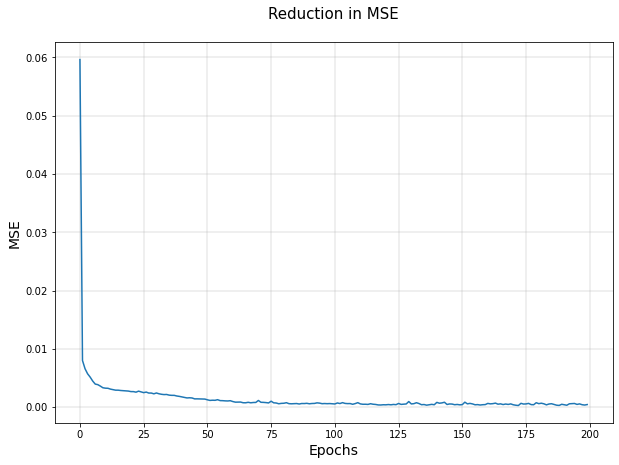

In [15]:
plt.figure(figsize=[10,7])
plt.title('Reduction in MSE\n', fontsize =15)
plt.ylabel('MSE',fontsize=14)
plt.xlabel('Epochs',fontsize=14)
plt.grid(linewidth=0.4)
plt.plot(history.history['mean_squared_error'])
plt.show()

Visualizamos también cómo se ajustan las predicciones del modelo a los datos reales de nivel de competencia. Los puntos azules indican las predicciones y la línea naranja indica dónde deberían encontrarse los valores para obtener un ajuste perfecto.

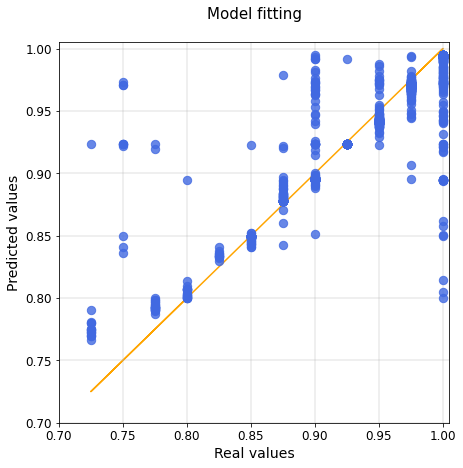

In [17]:
y_pred = model.predict(X_test)

plt.figure(figsize=[7,7])
plt.title('Model fitting\n', fontsize =15)
plt.ylabel('Predicted values',fontsize=14)
plt.xlabel('Real values',fontsize=14)
plt.xticks(fontsize=12) 
plt.yticks(fontsize=12)
plt.xlim([0.7,1.005])
plt.ylim([0.7,1.005])
plt.scatter(y_test, y_pred,linewidths=1, alpha=.8,s = 70, c='royalblue', zorder=2, label=None)
plt.plot(y_test,y_test, c='orange', zorder=1)
plt.grid(linewidth=0.4)
plt.show()

## 3. Conclusiones

En este problema hemos intentado predecir el nivel de competencia del sujeto que realiza cada ensayo de nuestra base de datos. El valor de error cuadrático medio (MSE) es óptimo e indica que el modelo puede predecir adecuadamente el nivel de competencia de un sujeto en una lengua, contando con la lengua en que el sujeto realiza el ensayo; la exposición, uso y preferencia de lectura del sujeto en esa lengua; el número de ítem que el sujeto lee en el ensayo y los milisegundos que tarda en leerlo; y la condición experimental a la que se somete.